In [1]:
'''
run S2J test. Check the processing 
'''

from data.SLP_RD import SLP_RD
from data.SLP_FD import SLP_FD
import argparse
import utils.vis as vis
import utils.utils as ut
import numpy as np
import opt
import cv2 
import skimage

# large opts
opts = opt.parseArgs()
# opt.print_options(opts)

----------------- Options ---------------
                   SLP_fd: /scratch/liu.shu/datasets/SLP/danaLab
                  SLP_set: danaLab                       
               batch_size: 60                            
            bbox_3d_shape: (2000, 2000, 2000)            
                bone_type: A2J                           
                 clipMode: 01                            
                   cov_li: ['uncover']                   
                depth_dim: 72                            
              display_env: main                          
               display_id: -1                            
            display_ncols: 3                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    ds_fd: /scratch/liu.shu/datasets     
                end_epoch: 12                            
               epoch_st

In [2]:
SLP_rd = SLP_RD(opts, phase='test')       #
SLP_fd = SLP_FD(SLP_rd, opts, if_sq_bb=True)
print(SLP_rd.n_subj)

102


In [ ]:
# test image pat 
idx = 0
rst = SLP_fd.SLP_A2J(idx)
pch, jt = rst['arr_tch'], rst['jt_tch']
print(pch.shape) 
pch_2d = pch.cpu().numpy()   #  tensor here
jt = jt.cpu().numpy()
pch_2d = pch_2d.transpose([1,2,0])    # to cv2 format
pch_2d = np.concatenate((pch_2d,)*3, axis=-1)

pch_2d_nm = ut.normImg(pch_2d)
jt[:,2] = 1 - jt[:, 2]
im_show = vis.vis_keypoints(pch_2d_nm, jt,  SLP_rd.skels_idx)
vis.ipyth_imshow(im_show)

(1, 288, 288)


In [23]:
print('pch min {} max {}'.format(pch.min(), pch.max()))
print('pch_nm min {} max {}'.format(pch_nm.min(), pch_nm.max()))

pch min -4.798148155212402 max 0.07407407462596893
pch_nm min 0 max 255


In [78]:
## SLP_A2J stepwise checking 
depthR, jt, bb = SLP_rd.get_array_joints(0, mod='depthRaw')
df_cut = 0.01  # 1 cm cut   turn later
std = 0.54
# define the fill and cut part
d_bed = SLP_rd.d_bed
d_cut = d_bed - df_cut
mean = d_cut + 0.5
bg = d_cut + 0.75  #
sz_pch= 288

depth = (depthR.astype(float)/1000.0 - mean) / std # after norm is good 

dp_gp, jt = ut.get_patch(depth, jt, bb, (sz_pch, sz_pch))  # error part 
## test get_patch 
img = depth 
new_Xmin = max(bb[0], 0)
new_Ymin = max(bb[1], 0)
new_Xmax = min(bb[0]+bb[2], img.shape[1] - 1)     # column - 1
new_Ymax = min(bb[1]+bb[3], img.shape[0] - 1)
print('img shape', img.shape) # 512  x424  
im_nm = ut.normImg(img.copy())# working good  
# min, max  190.4  56.5  310.86  408.4 
# int  
print('min x, y {},{} - max x, y {} {}'.format(new_Xmin, new_Ymin, new_Xmax, new_Ymax))
print('int turn min x, y {},{} - max x, y {} {}'.format(int(new_Xmin), int(new_Ymin), int(new_Xmax), int(new_Ymax)))
imCrop = img.copy()[int(new_Ymin):int(new_Ymax),int(new_Xmin):int(new_Xmax)]  
# cp1 = img.copy()[200:400, 200:300] # direct cut out patch # hand input good 
xl = int(new_Xmin) 
yl = int(new_Ymin)
xr  = int(new_Xmax)
yr = int(new_Ymax)
print(type(yl))
print(type(yr))
print(type(200))
# cp1 = img.copy()[int(56.5):int(408.4), 200:300] # if use int(float) indexing, will have wierd effect 
# cp1 = img.copy()[yl:yr, 200:300] # can't work even translated to int 
# cp1 = img.copy()[56:408, 190:310] # perhaps just too large local variations 
cp1 = img.copy()[56:408, 190:310]   # if 20: 408 cropping lower part , much better ? 

cp1_nm = ut.normImg(cp1)   # hand cropping works fine 
# print('new shape', [new_Xmin, new_Ymin, new_Xmax, new_Ymax])
# print(imCrop.shape)
im_cp_nm = ut.normImg(imCrop)
print('dpR_rs min {} max {}'.format(dpR_rs.min(), dpR_rs.max()))
imgResize = cv2.resize(imCrop, (sz_pch, sz_pch),
                       interpolation=cv2.INTER_NEAREST)
img_rs = ut.normImg(imgResize) 

dpR_rs = cv2.resize(depthR, (288, 288), interpolation=cv2.INTER_NEAREST) # work on originial 
dp_nm = ut.normImg(depth)  
dpR_rs_nm = ut.normImg(dpR_rs)  # pos norm good , 0 - 7459  no problem  
dp_gp_nm = ut.normImg(dp_gp)

dp_rs = cv2.resize(depth, (288, 288), interpolation=cv2.INTER_NEAREST)
dp_rs_nm = ut.normImg(dp_rs)

print('dpR_rs min {} max {}'.format(dpR_rs.min(), dpR_rs.max())) 

img shape (512, 424)
min x, y 190.40034718897977,56.519572812915044 - max x, y 310.8576196527001 408.3670458774129
int turn min x, y 190,56 - max x, y 310 408
<class 'int'>
<class 'int'>
<class 'int'>
dpR_rs min 0 max 7549
dpR_rs min 0 max 7549


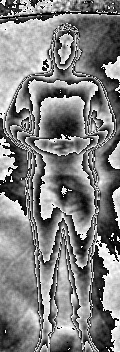

In [79]:
vis.ipyth_imshow(cp1_nm)

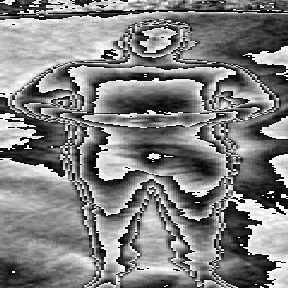

In [33]:
vis.ipyth_imshow(pch_nm)

In [14]:
print(pch_nm[240:260,240:260,0])

[[ 49  49  49  30  30   5   5   5 235 235 229 229 229 229 229 235 235 235
  235 235]
 [ 43  43  43  30  30   5   5   5 242 242 223 223 229 229 229 229 229 229
  229 229]
 [ 30  30  30  24  24  11  11  11 248 248 235 235 223 223 223 216 216 216
  216 216]
 [ 11  11  11  11  11  11  11  11 254 254 235 235 210 210 210 204 204 210
  210 210]
 [254 254 254   5   5   5   5   5 254 254 229 229 216 216 216 216 216 216
  216 216]
 [254 254 254   5   5   5   5   5 254 254 229 229 216 216 216 223 223 223
  223 223]
 [  5   5   5   5   5   5   5   5 242 242 229 229 216 216 216 229 229 223
  223 223]
 [ 11  11  11 254 254 242 242 242 223 223 216 216 210 210 210 216 216 210
  210 210]
 [ 18  18  18  11  11 248 248 248 235 235 223 223 216 216 216 216 216 204
  204 204]
 [ 24  24  24  24  24   5   5   5 248 248 229 229 223 223 223 216 216 210
  210 210]
 [ 30  30  30  24  24  11  11  11 248 248 229 229 223 223 223 223 223 216
  216 216]
 [ 24  24  24  24  24  11  11  11 248 248 229 229 229 229 229 229